In [12]:
import awkward as ak
import h5py
import numpy as np
import itertools
import random

In [56]:
def writeout(outfile, tree_to_arr):
    files = []
    for tree, data in tree_to_arr.items():

        outfile += f"_{tree}.parquet"
        ak.to_parquet(data, outfile)
        files.append(outfile)
        outfile = outfile.replace(f"_{tree}.parquet", "")    
                   
    
    return files
def readback(f, lazy=False, rg=None, cols = None):
    return ak.from_parquet(f, lazy=lazy, row_groups=rg, columns=cols, use_threads=True), None

In [36]:
chars = "abcdefghijklmnopqrstuvwxyz"
fields = []
for item in itertools.product(chars, repeat=3):
    fields.append("".join(item))

fields = fields[:30]
ny = [random.randint(1,5) for _ in range(len(fields))]
mydict = {f: np.random.normal(0, 1, (int(5e6), ny[i])) for i, f in enumerate(fields)}
akarr = ak.Array(mydict)

np_tree_to_arr = {"nl": akarr,
               "nl2": akarr}

In [37]:
outfile = "sample_chunkX"
files = writeout(outfile, np_tree_to_arr)

In [77]:
ncols = [3,6,12,16,20,len(fields)]
times = []
errs = []
for f in files:
    ftimes = []
    ferrs = []
    for n in ncols:
        print(f"Reading {n} columns")
        res = %timeit -r 2 -n 2 -o readback(f, lazy= True,cols=[f for f in fields[:n]])
        ftimes.append(res.average*1000)
        ferrs.append(res.stdev*1000)
    times.append(ftimes)
    errs.append(ferrs)

Reading 3 columns
4.66 ms ± 318 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 6 columns
8.06 ms ± 64.1 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 12 columns
14.6 ms ± 87.8 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 16 columns
18.7 ms ± 267 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 20 columns
24 ms ± 136 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 30 columns
34.5 ms ± 120 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 3 columns
4.24 ms ± 3.05 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 6 columns
7.68 ms ± 286 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 12 columns
14.7 ms ± 119 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 16 columns
18.7 ms ± 103 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 20 columns
23 ms ± 122 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
Reading 30 columns
34.9 ms ± 321 µs p

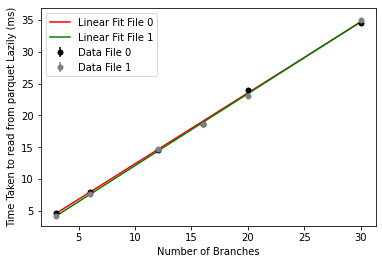

In [80]:
import matplotlib.pyplot as plt
from scipy import stats
lcs = ['red' , 'green']
datacs = ['black', 'grey']
for i, ftimes in enumerate(times):
    slope, intercept, r_value, p_value, std_err = stats.linregress(ncols,ftimes)
    plt.errorbar(ncols, ftimes, yerr=errs[i], ls = 'none',  marker = '.', ms=10, color = datacs[i], label=f'Data File {i}')
    time_linreg = slope*np.array(ncols) + intercept
    plt.plot(ncols, time_linreg, color = lcs[i], label = f'Linear Fit File {i}')
    plt.xlabel("Number of Branches")
    plt.ylabel("Time Taken to read from parquet Lazily (ms)")
    plt.legend()